# Bước 1: Import thư viện

In [4]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

# Bước 2: Đọc dữ liệu

In [5]:
#tạo quyền truy cập với google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# đọc dữ liệu từ file csv
df = pd.read_csv('/content/drive/MyDrive/FinanceData/Dữ liệu Lịch sử VNM.csv')

# Xóa hai dòng "KL" và "Thay đổi %" từ DataFrame dataSet
df = df.drop(columns=["KL", "% Thay đổi"])

# Hiển thị lại DataFrame sau khi xóa
print(df)

            Ngày  Lần cuối        Mở       Cao      Thấp
0     10/03/2025  62,500.0  63,000.0  63,000.0  62,500.0
1     07/03/2025  62,700.0  62,900.0  63,000.0  62,400.0
2     06/03/2025  62,900.0  62,700.0  62,900.0  62,200.0
3     05/03/2025  62,700.0  63,600.0  63,600.0  62,700.0
4     04/03/2025  63,500.0  63,200.0  63,800.0  62,900.0
...          ...       ...       ...       ...       ...
1288  08/01/2020  96,449.0  96,206.0  96,449.0  95,394.0
1289  07/01/2020  96,206.0  95,394.0  96,449.0  95,394.0
1290  06/01/2020  95,313.0  95,800.0  95,962.0  94,826.0
1291  03/01/2020  96,043.0  95,962.0  96,612.0  95,962.0
1292  02/01/2020  95,719.0  94,988.0  95,962.0  94,582.0

[1293 rows x 5 columns]


# Bước 3: Mô tả dữ liệu

In [7]:
#định dạng cấu trúc thời gian
df["Ngày"] = pd.to_datetime(df.Ngày,format="%d/%m/%Y")

In [8]:
#kích thước dữ liệu
df.shape

(1293, 5)

In [9]:
#dữ liệu 5 dòng đầu
df.head()

,Ngày,Lần cuối,Mở,Cao,Thấp
0,2025-03-10,"62,500.0","63,000.0","63,000.0","62,500.0"
1,2025-03-07,"62,700.0","62,900.0","63,000.0","62,400.0"
2,2025-03-06,"62,900.0","62,700.0","62,900.0","62,200.0"
3,2025-03-05,"62,700.0","63,600.0","63,600.0","62,700.0"
4,2025-03-04,"63,500.0","63,200.0","63,800.0","62,900.0"


In [10]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Ngày      1293 non-null   datetime64[ns]
 1   Lần cuối  1293 non-null   object        
 2   Mở        1293 non-null   object        
 3   Cao       1293 non-null   object        
 4   Thấp      1293 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 50.6+ KB


In [11]:
#mô tả bộ dữ liệu
df.describe()

,Ngày
count,1293
mean,2022-08-05 04:54:00.835266816
min,2020-01-02 00:00:00
25%,2021-04-20 00:00:00
50%,2022-08-04 00:00:00
75%,2023-11-17 00:00:00
max,2025-03-10 00:00:00


# Bước 4: Tiền xử lý dữ liệu

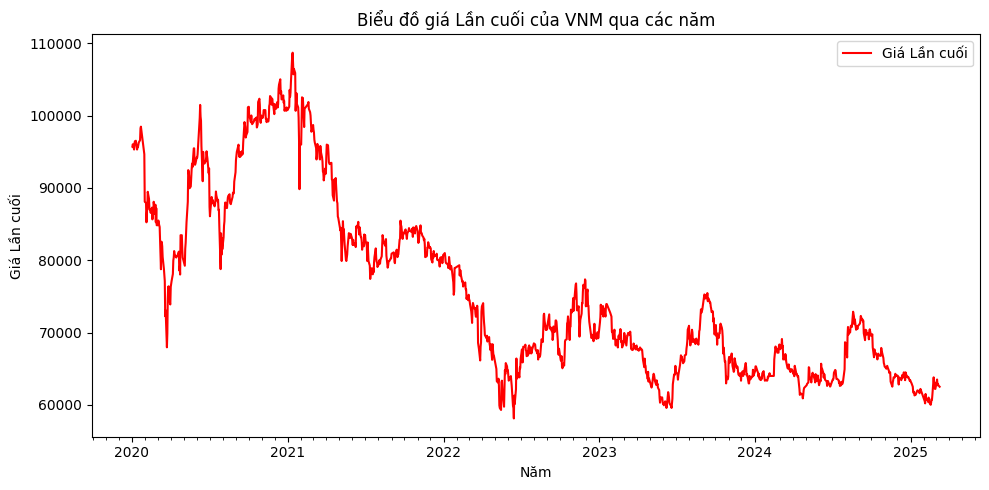

In [12]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngày')

# Chuyển đổi định dạng các cột giá thành số thực
df['Lần cuối'] = df['Lần cuối'].str.replace(',', '').astype(float)
df['Mở'] = df['Mở'].str.replace(',', '').astype(float)
df['Cao'] = df['Cao'].str.replace(',', '').astype(float)
df['Thấp'] = df['Thấp'].str.replace(',', '').astype(float)

# Lấy thông tin năm từ cột "Ngày"
df['Năm'] = df['Ngày'].dt.year

# Tạo đồ thị giá Lần cuối qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngày'], df['Lần cuối'], label='Giá Lần cuối', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá Lần cuối')
plt.title('Biểu đồ giá Lần cuối của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [13]:
df1 = pd.DataFrame(df,columns=['Ngày','Lần cuối'])
df1.index = df1.Ngày
df1.drop('Ngày',axis=1,inplace=True)
df1

,Lần cuối
Ngày,
2020-01-02,95719.0
2020-01-03,96043.0
2020-01-06,95313.0
2020-01-07,96206.0
2020-01-08,96449.0
...,...
2025-03-04,63500.0
2025-03-05,62700.0
2025-03-06,62900.0


In [14]:
#chia tập dữ liệu
data = df1.values
timestep = 50
train_size = len(data) - timestep
train_data = data[:train_size]
test_data = data[train_size:]

In [15]:
data

array([[95719.],
       [96043.],
       [95313.],
       ...,
       [62900.],
       [62700.],
       [62500.]])

In [16]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [17]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,train_size):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá Lần cuối liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá Lần cuối ngày hôm sau

In [18]:
x_train

[array([0.74327805, 0.74968226, 0.73525302, 0.75290413, 0.75770729,
        0.75450519, 0.75932811, 0.73525302, 0.74165723, 0.74165723,
        0.74808121, 0.75450519, 0.76092916, 0.79300953, 0.79783245,
        0.72240506, 0.59242326, 0.58922116, 0.53626781, 0.56194396,
        0.5763732 , 0.61970046, 0.60044829, 0.57157004, 0.57157004,
        0.56674711, 0.56194396, 0.5763732 , 0.54429284, 0.55872208,
        0.55872208, 0.59242326, 0.55872208, 0.58439823, 0.53626781,
        0.57477215, 0.52824278, 0.52824278, 0.54107097, 0.53304593,
        0.52824278, 0.52341985, 0.40788706, 0.48329469, 0.48169364,
        0.4704665 , 0.44158824, 0.40788706, 0.391837  , 0.37578694]),
 array([0.74968226, 0.73525302, 0.75290413, 0.75770729, 0.75450519,
        0.75932811, 0.73525302, 0.74165723, 0.74165723, 0.74808121,
        0.75450519, 0.76092916, 0.79300953, 0.79783245, 0.72240506,
        0.59242326, 0.58922116, 0.53626781, 0.56194396, 0.5763732 ,
        0.61970046, 0.60044829, 0.57157004, 0.

In [19]:
y_train

[np.float64(0.279506322183283),
 np.float64(0.2955563857312562),
 np.float64(0.19445284503189253),
 np.float64(0.2329571846765377),
 np.float64(0.3276367467390895),
 np.float64(0.35973687383503594),
 np.float64(0.3613379269722108),
 np.float64(0.3148085555535789),
 np.float64(0.3116064492792294),
 np.float64(0.35973687383503594),
 np.float64(0.3757869373830094),
 np.float64(0.39503910720533186),
 np.float64(0.4319621598009158),
 np.float64(0.43996742548678913),
 np.float64(0.4576185421719372),
 np.float64(0.44961327648606386),
 np.float64(0.44158824471207714),
 np.float64(0.43996742548678913),
 np.float64(0.44318929784925176),
 np.float64(0.4447903509864264),
 np.float64(0.4447903509864264),
 np.float64(0.4560174890347626),
 np.float64(0.4046651921164932),
 np.float64(0.41591209625294256),
 np.float64(0.39343805406815724),
 np.float64(0.500965573404333),
 np.float64(0.500965573404333),
 np.float64(0.4640425208087491),
 np.float64(0.43996742548678913),
 np.float64(0.4175131493901172),
 

In [20]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

# Bước 5: Xây dựng và huấn luyện mô hình

In [21]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
#huấn luyện mô hình
save_model = "/content/drive/MyDrive/FinanceData/save_model.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.10508, saving model to /content/drive/MyDrive/FinanceData/save_model.keras
24/24 - 10s - 425ms/step - loss: 0.1051
Epoch 2/100

Epoch 2: loss improved from 0.10508 to 0.05809, saving model to /content/drive/MyDrive/FinanceData/save_model.keras
24/24 - 4s - 173ms/step - loss: 0.0581
Epoch 3/100

Epoch 3: loss improved from 0.05809 to 0.05541, saving model to /content/drive/MyDrive/FinanceData/save_model.keras
24/24 - 4s - 180ms/step - loss: 0.0554
Epoch 4/100

Epoch 4: loss improved from 0.05541 to 0.05232, saving model to /content/drive/MyDrive/FinanceData/save_model.keras
24/24 - 3s - 141ms/step - loss: 0.0523
Epoch 5/100

Epoch 5: loss improved from 0.05232 to 0.04974, saving model to /content/drive/MyDrive/FinanceData/save_model.keras
24/24 - 4s - 186ms/step - loss: 0.0497
Epoch 6/100

Epoch 6: loss did not improve from 0.04974
24/24 - 6s - 267ms/step - loss: 0.0522
Epoch 7/100

Epoch 7: loss improved from 0.04974 to 0.04727, saving 

In [23]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("/content/drive/MyDrive/FinanceData/save_model.keras")
y_train_predict = final_model.predict(x_train) #dự đoán giá Lần cuối trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


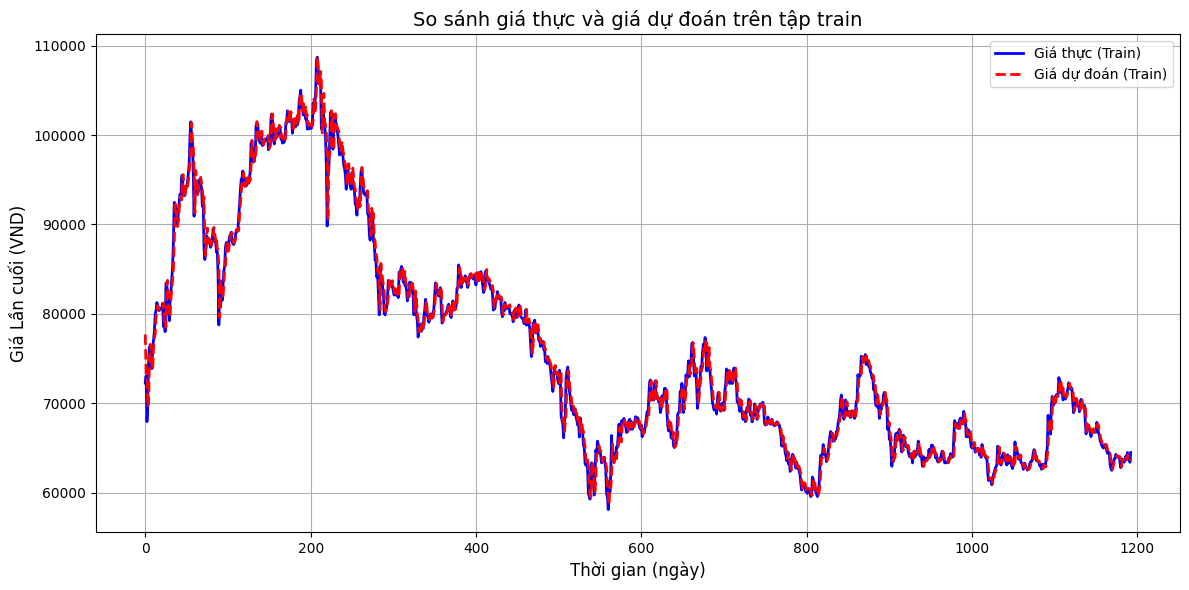

In [24]:
# Vẽ biểu đồ so sánh y_train và y_train_predict
plt.figure(figsize=(12, 6))  # Kích thước biểu đồ (rộng 12, cao 6)
plt.plot(y_train, label='Giá thực (Train)', color='blue', linewidth=2)  # Đường giá thực
plt.plot(y_train_predict, label='Giá dự đoán (Train)', color='red', linestyle='--', linewidth=2)  # Đường giá dự đoán
plt.title('So sánh giá thực và giá dự đoán trên tập train', fontsize=14)  # Tiêu đề
plt.xlabel('Thời gian (ngày)', fontsize=12)  # Nhãn trục x
plt.ylabel('Giá Lần cuối (VND)', fontsize=12)  # Nhãn trục y
plt.legend(loc='best')  # Hiển thị chú thích
plt.grid(True)  # Thêm lưới
plt.tight_layout()  # Tối ưu bố cục
plt.show()  # Hiển thị biểu đồ

# Bước 6: Tái sử dụng mô hình

In [25]:
#xử lý dữ liệu test
test = df1[train_size - timestep:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50, test.shape[0]):
  x_test.append(sc_test[i-50:i, 0])

x_test = np.array(x_test)
print(x_test.shape)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[train_size:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

(50, 50)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


# Độ chính xác của mô hình

<ipython-input-26-74d947f02f70>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
<ipython-input-26-74d947f02f70>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


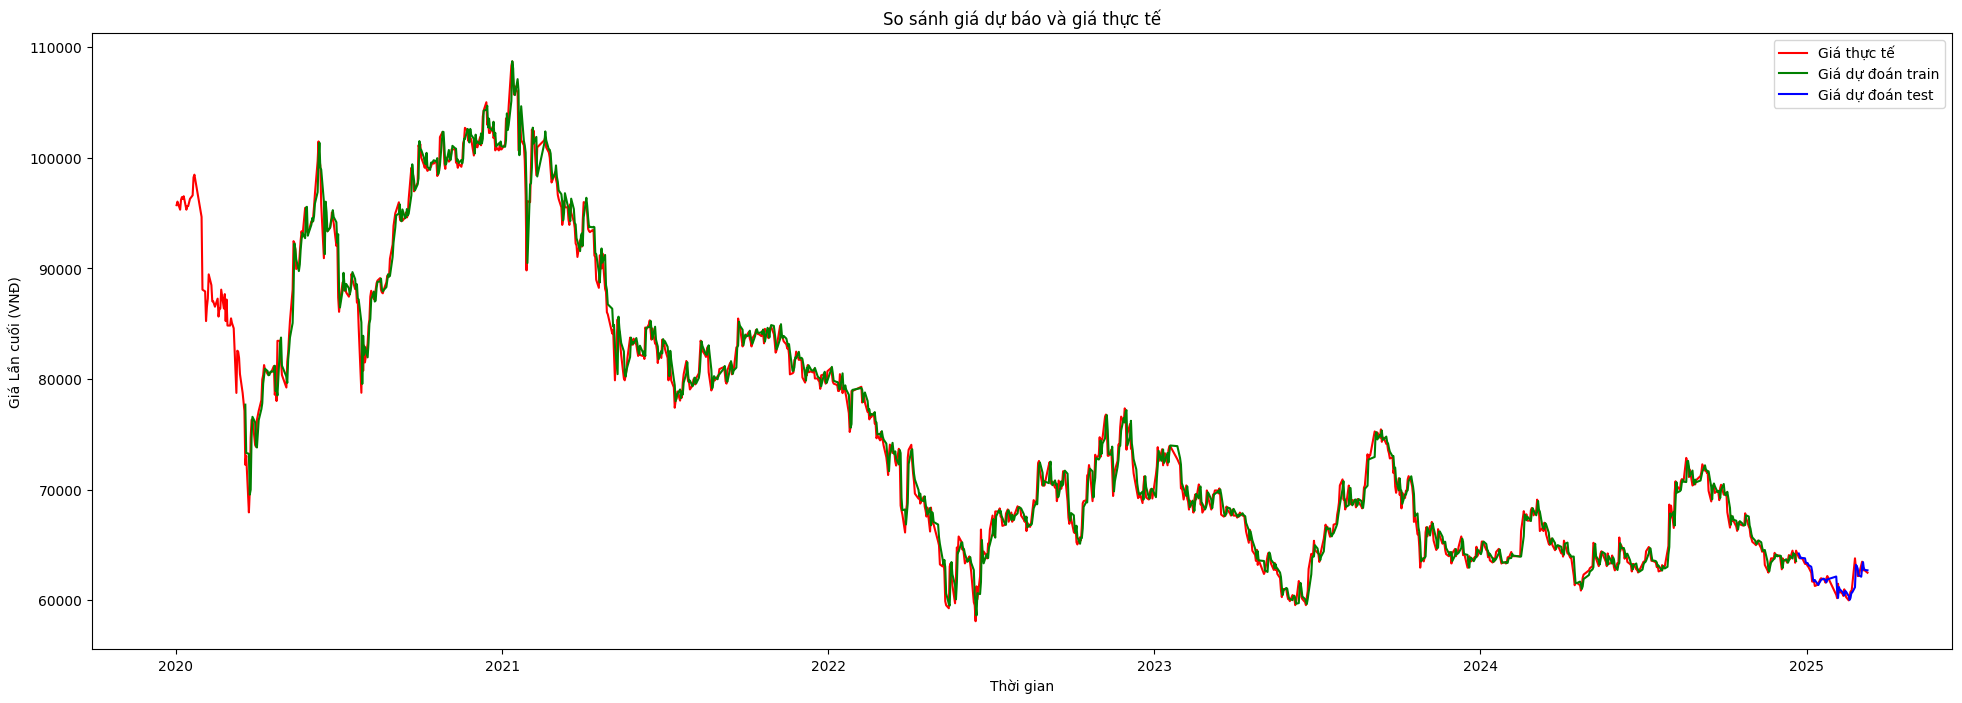

In [26]:
#lập biểu đồ so sánh
train_data1 = df1[50:train_size]
test_data1 = df1[train_size:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá Lần cuối (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [27]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9907575687369802
Sai số tuyệt đối trung bình trên tập train (VNĐ): 798.7966595505031
Phần trăm sai số tuyệt đối trung bình tập train: 0.010514508925676373


In [28]:
train_data1

,Lần cuối,Dự đoán
Ngày,,
2020-03-19,72256.0,77691.828125
2020-03-20,73068.0,73324.625000
2020-03-23,67953.0,73251.734375
2020-03-24,69901.0,69558.742188
2020-03-25,74691.0,70002.664062
...,...,...
2024-12-16,64495.3,63787.742188
2024-12-17,64098.4,64275.980469
2024-12-18,64197.7,64177.796875


In [29]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.7128620025354139
Sai số tuyệt đối trung bình trên tập test (VNĐ): 399.9887656249999
Phần trăm sai số tuyệt đối trung bình tập test: 0.006453199975719633


In [30]:
test_data1

,Lần cuối,Dự đoán
Ngày,,
2024-12-23,63900.0,64234.945312
2024-12-24,63800.8,64074.015625
2024-12-25,63900.0,63797.324219
2024-12-26,63800.0,63847.429688
2024-12-27,63800.0,63832.582031
2024-12-30,63300.0,63803.988281
2024-12-31,63400.0,63408.203125
2025-01-02,63100.0,63367.839844
2025-01-03,63000.0,63189.289062


# Thử dự đoán giá tương lai và so sánh với giá ngày cuối

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


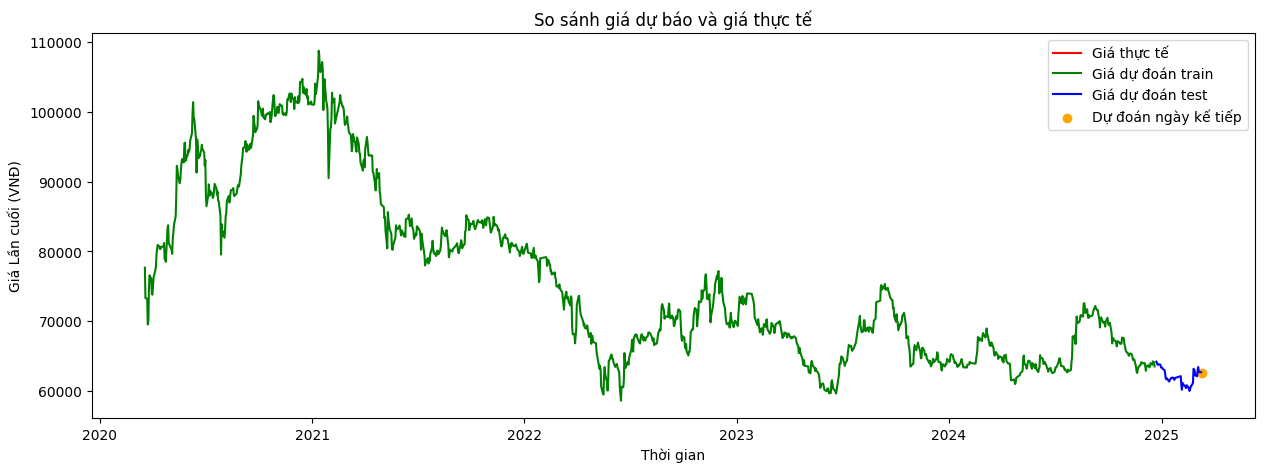

In [31]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Ngày'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Lần cuối'].iloc[-1]])  # Lấy giá trị Lần cuối của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá Lần cuối gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Ngày': [next_date], 'Lần cuối': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Ngày'], df1['Lần cuối'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá Lần cuối (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()


In [32]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Lần cuối'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Ngày': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

        Ngày  Giá dự đoán  Giá ngày trước
0 2025-03-11  62549.46875         62500.0
